In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy

import os
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def Kernel(x, x0):
    sigma = 0.8
    protonFraction = 0.4
    norm = protonFraction/(np.sqrt(2.*np.pi)*sigma)
    return(norm*np.exp(-(x - x0)**2./(2.*sigma**2.)))

def testDataGen():
    A = 197
    yBeam = 5.36
    slope = 0.5
    sigmaEtas = 0.2
    
    # generate input data
    nBaryons = np.random.randint(0, 2*A)
    randX = np.random.uniform(0, 1, size=nBaryons)
    etasBaryon = 1./slope*np.arcsinh((2.*randX - 1)*np.sinh(slope*yBeam))
    etasArr = np.linspace(-6.4, 6.4, 128)
    dNBdetas = np.zeros(len(etasArr))
    norm = 1./(np.sqrt(2.*np.pi)*sigmaEtas)
    for iB in etasBaryon:
        dNBdetas += norm*np.exp(-(etasArr - iB)**2./(2.*sigmaEtas**2.))
    
    # generate test data with convolution with a kernel
    dNpdy = np.zeros(len(etasArr))
    detas = etasArr[1] - etasArr[0]
    for i in range(len(etasArr)):
        dNpdy[i] = sum(Kernel(etasArr, etasArr[i])*dNBdetas)*detas
        
    # generate fake data with random noise
    dNBdetasFake = np.random.uniform(0.0, dNBdetas.max(), size=len(etasArr))
    dNpdyFake = np.random.uniform(0.0, dNpdy.max(), size=len(etasArr))
    return(etasArr, dNBdetas, dNpdy, dNBdetasFake, dNpdyFake)

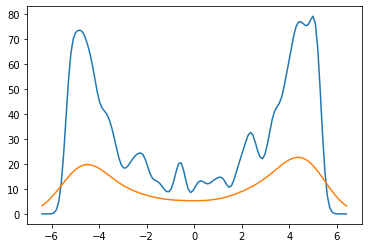

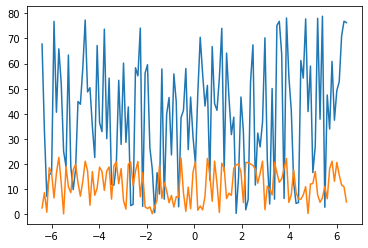

In [13]:
x, y1, y2, y3, y4 = testDataGen()
fig = plt.figure()
plt.plot(x, y1)
plt.plot(x, y2)
fig = plt.figure()
plt.plot(x, y3)
plt.plot(x, y4)

In [86]:
def generateData(size=500):
    print('Generating Data...')
    dataArr = []
    labelArr = []  
    for iev in range(size):
        x, y1, y2, y3, y4 = testDataGen()
        
        dim = len(x)
        
        # real data
        #x = np.hstack((y1.reshape(dim, 1), y2.reshape(dim, 1)))
        x = y2
        dataArr.append(x)
        labelArr.append(1)
        
        # fake data
        #x = np.hstack((y3.reshape(dim, 1), y4.reshape(dim, 1)))
        x = y4
        dataArr.append(x)
        labelArr.append(0)
        
    print("done")
    return(np.array(dataArr), np.array(labelArr))

In [87]:
def trainModel(dimShape):
    #Sequential model
    model = Sequential([
        Dense(units=32, activation='relu', input_shape=dimShape),
        Dense(units=16, activation='relu'),
        Dense(units=4, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    model.summary()
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return(model)

In [88]:
data, label = generateData(5000)

Generating Data...
done


In [89]:
model = trainModel(data.shape[1:])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 32)                4128      
                                                                 
 dense_46 (Dense)            (None, 16)                528       
                                                                 
 dense_47 (Dense)            (None, 4)                 68        
                                                                 
 dense_48 (Dense)            (None, 1)                 5         
                                                                 
Total params: 4,729
Trainable params: 4,729
Non-trainable params: 0
_________________________________________________________________


In [90]:
Nepochs = 100
#Fit will actually train the model.
# X: input of shape (141,2)
# Y: target catagorization, either 1 or 0. Shape (141,2) for consistancy with X
model.fit(
    x=np.array(data),
    y=np.array(label),
    epochs=Nepochs,
    shuffle=True,
    validation_split=0.1,
    use_multiprocessing=True,
    workers=25,
    verbose=2
)

Epoch 1/100
282/282 - 1s - loss: 0.3595 - accuracy: 0.8991 - val_loss: 0.1315 - val_accuracy: 0.9760 - 689ms/epoch - 2ms/step
Epoch 2/100
282/282 - 0s - loss: 0.0863 - accuracy: 0.9830 - val_loss: 0.0748 - val_accuracy: 0.9890 - 213ms/epoch - 754us/step
Epoch 3/100
282/282 - 0s - loss: 0.0584 - accuracy: 0.9903 - val_loss: 0.0550 - val_accuracy: 0.9940 - 213ms/epoch - 754us/step
Epoch 4/100
282/282 - 0s - loss: 0.0470 - accuracy: 0.9930 - val_loss: 0.0450 - val_accuracy: 0.9940 - 212ms/epoch - 751us/step
Epoch 5/100
282/282 - 0s - loss: 0.0396 - accuracy: 0.9947 - val_loss: 0.0383 - val_accuracy: 0.9950 - 219ms/epoch - 778us/step
Epoch 6/100
282/282 - 0s - loss: 0.0344 - accuracy: 0.9950 - val_loss: 0.0327 - val_accuracy: 0.9950 - 211ms/epoch - 748us/step
Epoch 7/100
282/282 - 0s - loss: 0.0294 - accuracy: 0.9956 - val_loss: 0.0272 - val_accuracy: 0.9950 - 215ms/epoch - 761us/step
Epoch 8/100
282/282 - 0s - loss: 0.0251 - accuracy: 0.9956 - val_loss: 0.0232 - val_accuracy: 0.9950 - 213

In [95]:
# generate testing data
testData, testLabels = generateData(100)

Generating Data...
done


In [97]:
predictions = model.predict(testData)

(-0.05, 1.05)

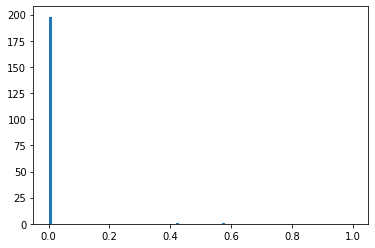

In [113]:
fig = plt.figure()
plt.hist(abs(predictions.reshape(200) - testLabels), 50);
plt.xlim([-0.05, 1.05])